In [45]:
import pandas as pd
import numpy as np

In [46]:
#Load the Wikipedia table
url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
tables = pd.read_html(url)

In [47]:
tables[0]

,Symbol,Security,GICS Sector,GICS Sub-Industry,Headquarters Location,Date added,CIK,Founded
0,MMM,3M,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1957-03-04,66740,1902
1,AOS,A. O. Smith,Industrials,Building Products,"Milwaukee, Wisconsin",2017-07-26,91142,1916
2,ABT,Abbott Laboratories,Health Care,Health Care Equipment,"North Chicago, Illinois",1957-03-04,1800,1888
3,ABBV,AbbVie,Health Care,Biotechnology,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
4,ACN,Accenture,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989
...,...,...,...,...,...,...,...,...
498,XYL,Xylem Inc.,Industrials,Industrial Machinery & Supplies & Components,"White Plains, New York",2011-11-01,1524472,2011
499,YUM,Yum! Brands,Consumer Discretionary,Restaurants,"Louisville, Kentucky",1997-10-06,1041061,1997
500,ZBRA,Zebra Technologies,Information Technology,Electronic Equipment & Instruments,"Lincolnshire, Illinois",2019-12-23,877212,1969
501,ZBH,Zimmer Biomet,Health Care,Health Care Equipment,"Warsaw, Indiana",2001-08-07,1136869,1927


In [48]:
#Find the table that contains the 'Date added' column
sp500_additions = None
for table in tables:
    if 'Date added' in table.columns:
        sp500_additions = table
        break

#Drop rows with missing 'Date added'
sp500_additions = sp500_additions.dropna(subset=["Date added"])

#Convert 'Date added' to datetime and extract the year
sp500_additions["Year added"] = pd.to_datetime(sp500_additions["Date added"]).dt.year
sp500_additions.head()

,Symbol,Security,GICS Sector,GICS Sub-Industry,Headquarters Location,Date added,CIK,Founded,Year added
0,MMM,3M,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1957-03-04,66740,1902,1957
1,AOS,A. O. Smith,Industrials,Building Products,"Milwaukee, Wisconsin",2017-07-26,91142,1916,2017
2,ABT,Abbott Laboratories,Health Care,Health Care Equipment,"North Chicago, Illinois",1957-03-04,1800,1888,1957
3,ABBV,AbbVie,Health Care,Biotechnology,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888),2012
4,ACN,Accenture,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989,2011


In [49]:
#Exclude the year 1957
sp500_additions = sp500_additions[sp500_additions["Year added"] != 1957]

#Count the number of additions per year
additions_per_year = sp500_additions["Year added"].value_counts().sort_index()
# additions_per_year

In [50]:
sp500_additions["Year added"].value_counts().head()

,count
Year added,
2017,23
2016,23
2019,22
2008,17
2024,16


In [51]:
#Identify the year with the most additions
most_additions_year = additions_per_year.idxmax()
most_additions_count = additions_per_year.max()

print(f"Year with the most additions: {most_additions_year} ({most_additions_count} companies)")

Year with the most additions: 2016 (23 companies)


In [52]:
!pip -q install yfinance

In [53]:
import yfinance as yf
from datetime import datetime

In [54]:
from datetime import datetime

END = pd.Timestamp("2025-05-01")
START_YTD = pd.Timestamp(f"{END.year}-01-01")

TICKERS = {
    "United States - S&P 500": "^GSPC",
    "China - Shanghai Composite": "000001.SS",
    "Hong Kong - Hang Seng": "^HSI",
    "Australia - ASX 200": "^AXJO",
    "India - Nifty 50": "^NSEI",
    "Canada - TSX Composite": "^GSPTSE",
    "Germany - DAX": "^GDAXI",
    "United Kingdom - FTSE 100": "^FTSE",
    "Japan - Nikkei 225": "^N225",
    "Mexico - IPC Mexico": "^MXX",
    "Brazil - Ibovespa": "^BVSP"
}

HORIZONS = {
    "YTD":  (START_YTD, END),
    "3Y":   (END - pd.DateOffset(years=3),  END),
    "5Y":   (END - pd.DateOffset(years=5),  END),
    "10Y":  (END - pd.DateOffset(years=10), END),
}

EARLIEST = min(start for start, _ in HORIZONS.values())
print(f"Earliest date to download: {EARLIEST:%Y-%m-%d}")


Earliest date to download: 2015-05-01


In [55]:
# ---- Bulk download -------------------------------------------------
raw = yf.download(
    list(TICKERS.values()),
    start=EARLIEST,
    end=END,
    progress=False,
    group_by="ticker",      # 1st level = ticker
    auto_adjust=False       # keep both 'Close' and 'Adj Close' if available
)

# ---- Choose price field -------------------------------------------
lvl1 = raw.columns.get_level_values(1).unique()
pick = "Adj Close" if "Adj Close" in lvl1 else "Close"
print(f"Using price field: {pick}")

prices = (
    raw.xs(pick, axis=1, level=1)
       .rename(columns={v: k for k, v in TICKERS.items()})
       .dropna(how="all")
)

print("Price table shape:", prices.shape)



Using price field: Adj Close
Price table shape: (2606, 11)


In [56]:
prices.tail()

Ticker,Germany - DAX,Australia - ASX 200,Hong Kong - Hang Seng,Brazil - Ibovespa,China - Shanghai Composite,Japan - Nikkei 225,United Kingdom - FTSE 100,Mexico - IPC Mexico,Canada - TSX Composite,India - Nifty 50,United States - S&P 500
Date,,,,,,,,,,,
2025-04-24,+2206450.98%,+796820.02%,+2190975.98%,+13458000.00%,+329728.81%,+3503914.84%,+840740.04%,+5638200.00%,+2472750.00%,+2424669.92%,+548477.00%
2025-04-25,+2224244.92%,NaN,+2198074.02%,+13473900.00%,+329506.01%,+3570573.83%,+841529.98%,+5672012.11%,+2471050.00%,+2403934.96%,+552521.00%
2025-04-28,+2227166.99%,+799710.01%,+2197196.09%,+13501600.00%,+328841.50%,+3583998.83%,+841729.98%,+5698012.89%,+2479859.96%,+2432850.00%,+552875.00%
2025-04-29,+2242583.01%,+807060.01%,+2200810.94%,+13509300.00%,+328665.50%,NaN,+846350.00%,+5561342.97%,+2487450.00%,+2433594.92%,+556083.01%
2025-04-30,+2249698.05%,+812620.02%,+2211941.02%,+13506700.00%,+327903.10%,+3604537.89%,+849490.04%,+5625928.12%,+2484169.92%,+2433419.92%,+556906.01%


In [57]:
# ---------- helper functions (revised) -----------------
def clean_prices(df: pd.DataFrame, end: pd.Timestamp) -> pd.DataFrame:
    """
    Forward-fill to `end`, back-fill just once (in case start date is a holiday),
    and keep only rows inside [earliest, end].
    """
    out = df.ffill(limit=5).bfill(limit=1)          # small gaps only
    # make sure we have a row exactly on `end`
    if out.index.max() < end:
        last_row = out.iloc[[-1]].copy()
        last_row.index = [end]
        out = pd.concat([out, last_row])
    return out

def period_return(series: pd.Series,
                  start: pd.Timestamp,
                  end: pd.Timestamp) -> float:
    seg = series.loc[start:end].dropna()
    if seg.empty:
        return float("nan")
    return (seg.iloc[-1] / seg.iloc[0]) - 1


In [58]:
# def period_return(series: pd.Series, start: pd.Timestamp, end: pd.Timestamp) -> float:
#     start_px = series.loc[series.index >= start].iloc[0]
#     end_px   = series.loc[series.index <= end].iloc[-1]
#     return (end_px / start_px) - 1

def horizon_returns(df: pd.DataFrame, horizons: dict) -> pd.DataFrame:
    out = {}
    for label, (start, end) in horizons.items():
        out[label] = df.apply(period_return, axis=0, start=start, end=end)
    return pd.DataFrame(out)


In [59]:
prices = clean_prices(prices, END)

In [60]:
returns = horizon_returns(prices, HORIZONS).T.round(4)

benchmark = returns["United States - S&P 500"]
beats = (returns.drop(columns="United States - S&P 500")
                 .gt(benchmark, axis=0)
                 .sum(axis=1))

pd.options.display.float_format = "{:+.2%}".format

print("Indexes that beat the S&P 500")
print(beats.to_frame("Count > S&P"))

print("\nTotal returns by horizon")
returns


Indexes that beat the S&P 500
     Count > S&P
YTD            9
3Y             3
5Y             2
10Y            1

Total returns by horizon


Ticker,Germany - DAX,Australia - ASX 200,Hong Kong - Hang Seng,Brazil - Ibovespa,China - Shanghai Composite,Japan - Nikkei 225,United Kingdom - FTSE 100,Mexico - IPC Mexico,Canada - TSX Composite,India - Nifty 50,United States - S&P 500
YTD,+13.00%,-0.40%,+10.27%,+12.29%,-2.17%,-9.65%,+3.94%,+13.62%,+0.46%,+2.49%,-5.31%
3Y,+61.40%,+10.61%,+4.88%,+26.66%,+7.61%,+34.40%,+12.60%,+8.43%,+20.05%,+42.56%,+34.02%
5Y,+107.12%,+54.91%,-10.24%,+67.77%,+14.65%,+83.72%,+47.40%,+54.26%,+69.91%,+146.80%,+96.74%
10Y,+93.61%,+39.76%,-21.35%,+135.50%,-26.81%,+84.55%,+21.60%,+24.36%,+61.94%,+192.06%,+164.15%


In [61]:
# ---------------- 1. Download daily history (1950-today) ------------
raw = yf.download("^GSPC",
                  start="1950-01-01",
                  auto_adjust=False,      # <-- ADDED
                  progress=False)

gspc = raw["Adj Close"]          # now the column is guaranteed to exist

# Make sure gspc is a Series
gspc = raw["Close"].squeeze()     # squeeze collapses single-column DataFrame to Series
gspc.name = "SP500"

cummax = gspc.cummax()
is_ath = gspc > cummax.shift(fill_value=0)

# Keep date/price of every ATH
ath_ser = gspc[is_ath]
ath_df  = ath_ser.rename("ath_price").to_frame()
ath_df["ath_date"] = ath_df.index

# ---------------- 3-6. Scan consecutive ATH pairs ------------------
records = []
for (prev_date, prev_row), (next_date, next_row) in zip(ath_df.iloc[:-1].iterrows(),
                                                        ath_df.iloc[1:].iterrows()):
    window = gspc.loc[prev_date:next_date]        # inclusive
    # ATH → new ATH measures fall + recovery
    # low_px = window.min()
    # drawdown = (prev_row.ath_price - low_px) / prev_row.ath_price * 100
    # if drawdown >= 5:                             # 5 % threshold
    #     duration = (next_date - prev_date).days
    #     records.append({
    #         "start"    : prev_date,
    #         "end"      : next_date,
    #         "days"     : duration,
    #         "drawdown%": round(drawdown, 2),
    #     })

    #ATH → trough measures how long the market falls
    low_px   = window.min()
    trough   = window.idxmin()               # <-- date of the low
    drawdown = (prev_row.ath_price - low_px) / prev_row.ath_price * 100
    if drawdown >= 5:
        duration = (trough - prev_date).days # <-- use trough, not next ATH
        records.append({
            "start"      : prev_date,
            "trough"     : trough,
            "end_ath"    : next_date,
            "days"       : duration,
            "drawdown%"  : round(drawdown, 2),
        })

corr = pd.DataFrame(records)
corr.head()


,start,trough,end_ath,days,drawdown%
0,1950-06-12,1950-07-17,1950-09-22,35,+1402.00%
1,1950-11-24,1950-12-04,1950-12-28,10,+650.00%
2,1951-05-03,1951-06-29,1951-08-02,57,+811.00%
3,1951-10-15,1951-11-23,1952-01-03,39,+608.00%
4,1952-01-22,1952-02-20,1952-06-26,29,+637.00%


In [62]:
if corr.empty:
    print("No corrections ≥ 5 % found (unexpected).")
else:
    percentiles = np.percentile(corr["days"], [25, 50, 75]).astype(int)
    print("Correction duration percentiles (days)")
    print(f"25th: {percentiles[0]}\n50th (median): {percentiles[1]}\n75th: {percentiles[2]}")
    with pd.option_context("display.float_format", "{:,.0f}".format):
      display(corr.describe()[["days", "drawdown%"]])



Correction duration percentiles (days)
25th: 21
50th (median): 39
75th: 89


,days,drawdown%
count,71,71
mean,113,13
min,7,5
25%,22,6
50%,39,8
75%,89,14
max,929,57
std,179,11


In [64]:
corr = pd.DataFrame(records)
top10 = corr.sort_values("drawdown%", ascending=False).head(10)

for _, r in top10.iterrows():
    print(f"{r.start.date()} to {r.trough.date()}: "
          f"{r['drawdown%']:.1f}% drawdown over {int(r.days)} days")


2007-10-09 to 2009-03-09: 56.8% drawdown over 517 days
2000-03-24 to 2002-10-09: 49.1% drawdown over 929 days
1973-01-11 to 1974-10-03: 48.2% drawdown over 630 days
1968-11-29 to 1970-05-26: 36.1% drawdown over 543 days
2020-02-19 to 2020-03-23: 33.9% drawdown over 33 days
1987-08-25 to 1987-12-04: 33.5% drawdown over 101 days
1961-12-12 to 1962-06-26: 28.0% drawdown over 196 days
1980-11-28 to 1982-08-12: 27.1% drawdown over 622 days
2022-01-03 to 2022-10-12: 25.4% drawdown over 282 days
1966-02-09 to 1966-10-07: 22.2% drawdown over 240 days


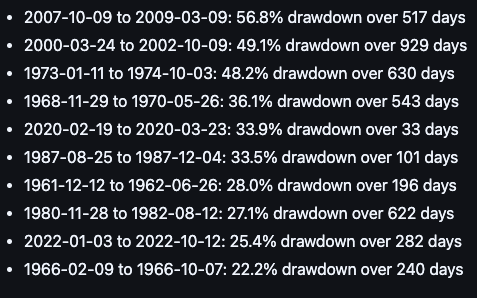